<center>
<div style="max-width:400px;">

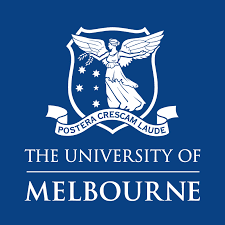

</div>
</center>

# Measurement Systems Analysis

**Prof. Kevin Otto and Nikolas Crossan**  
The University of Melbourne  
Department of Mechanical Engineering

-------------------------------------------------------------------

Herein are notes, examples and code to compute a gauge repeatability and reproducibility analysis.  

This notebook relies on the `mqrpy` code library, found at https://pypi.org/project/mqrpy/

In [1]:
import mqr
from mqr.plot import Figure
from mqr.nbtools import hstack, vstack

import numpy as np
import pandas as pd

from importlib.metadata import version
print('MQR version', version('mqrpy'))
print('Numpy version', version('numpy'))
print('Scipy version', version('scipy'))
print('Pandas version', version('pandas'))

MQR version 0.6.0
Numpy version 1.26.4
Scipy version 1.13.1
Pandas version 2.2.2


-----------------------------------------------------------------------------------------------------------
# 1.0 Import GRR Study Data

Read GRR data in from an XLSX file into a Pandas dataframe.  

The file's first row must be text labels, typically "Part", "Operator", and "NAME" where NAME is the name for the measured data.

One column must be the part number.  Text values are not allowed, data entries must be numbers.

Another column must be the operator number.  Text values are not allowed, data entries must be numbers.  

A third column must be the measurement. 

In [2]:
data = pd.read_csv(mqr.sample_data('grr.csv'))
data.head()

,Part,Operator,Height
0,1,1,9.347
1,1,1,9.230
2,1,1,9.202
3,1,2,9.365
4,1,2,9.423


-----------------------------------------------------------------------------------------------------
# 2.0 Study Setup

Set the specification limits and the study variation range (typically 6 or 5.15 sigma).  

Here the upper specification limit USL = 10.5, and the lower specification limit LSL = 7.5.

Set whether to include the Part-Operator interaction term in the analysis or not.

Also, you need to tell the MQR GRR fucntion which columns in the Pandas dataframe correspond to parts, opertors, replicates and the measurements.  Using the function `NameMapping` identify which Pandas dataframe column names correspond to measurements, parts, operators, and replicate.  

In [3]:
USL = 10.5
LSL = 7.5
SV = 6.0
Include_Interaction = True
tol = np.absolute(USL - LSL)

name_mapping = mqr.msa.NameMapping(
    measurement='Height',
    part='Part',
    operator='Operator')

-------------------------------------------------------------------------------------------
# 3.0 GRR ANOVA

Compute the GRR ANOVA analysis display the statistics.

In [4]:
grr = mqr.msa.GRR(
    data,
    tolerance=tol,
    names=name_mapping,
    include_interaction=True,
    nsigma=SV)
result = grr.regression_result

vstack(
    '### GRR Data Input',
    grr,
    '### GRR ANOVA Summary Statistics',
     mqr.anova.adequacy(result),
    '### GRR ANOVA Table',
    mqr.anova.summary(result))

The result is that $r^2$ is rather good.  The ANOVA table show the parts are significantly different compared to the residual error, which is good.  However, it also shows the operators are significantly different as well, not good. Also, there is no significant interaction between parts and operators. Given that last result, we ought go back to block 3 and reset `Include_Interaction` to False.  

Now create the residuals analysis to ensure residuals are properly distributed.


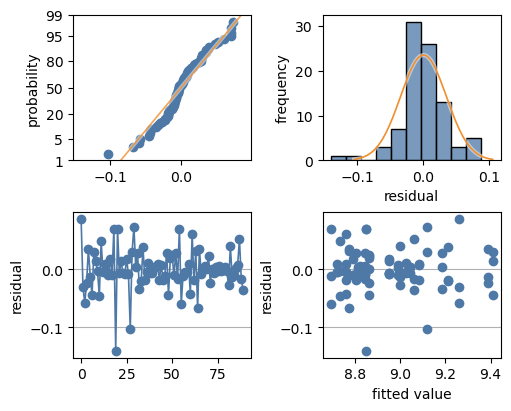

In [5]:
with Figure(5, 4, 2, 2) as (fig, ax):
    mqr.plot.regression.residuals(result.resid, result.fittedvalues, axs=ax)
    plot = mqr.nbtools.grab_figure(fig)
vstack(
   '### GRR Residuals',
    hstack(
        plot,
        mqr.inference.dist.test_1sample(result.resid),
    )
)

-----------------------------------------------------------------------------------------------
# 4.0 GRR Summary

Now create the GRR table and print out.

In [6]:
vstack(
    '### GRR Table',
    mqr.msa.VarianceTable(grr) )

,VarComp,% Contribution,StdDev,StudyVar (6.0*SD),% StudyVar,% Tolerance
Gauge RR,0.003208,7.522,0.05664,0.3398,27.43,11.33
Repeatability,0.001811,4.247,0.04256,0.2553,20.61,8.512
Reproducibility,0.001397,3.276,0.03738,0.2243,18.1,7.475
Operator,0.00138,3.236,0.03715,0.2229,17.99,7.43
Operator*Part,1.699e-05,0.03984,0.004122,0.02473,1.996,0.8244
Part-to-Part,0.03944,92.48,0.1986,1.192,96.17,39.72
Total,0.04265,100,0.2065,1.239,100,41.3


These results indicate a study variation of 0.34, or $\pm$0.17 measurement error (3-sigma).  The P/TV ratio is 27.4%, indicating poor ability to study the process variation. As it is, the measurement system cannot monitor the process for shifts.  The P/T ratio is 11.3%, indicating good ability to study whether or not a part is defective (not in specification).

The percent contribution shows 3.2% out of 7.5% is due to operator.  This is too high, the operator-operator contribution ought be scrutinized.  

### GRR Graphical Summary

Now create the GRR Graphical Summary

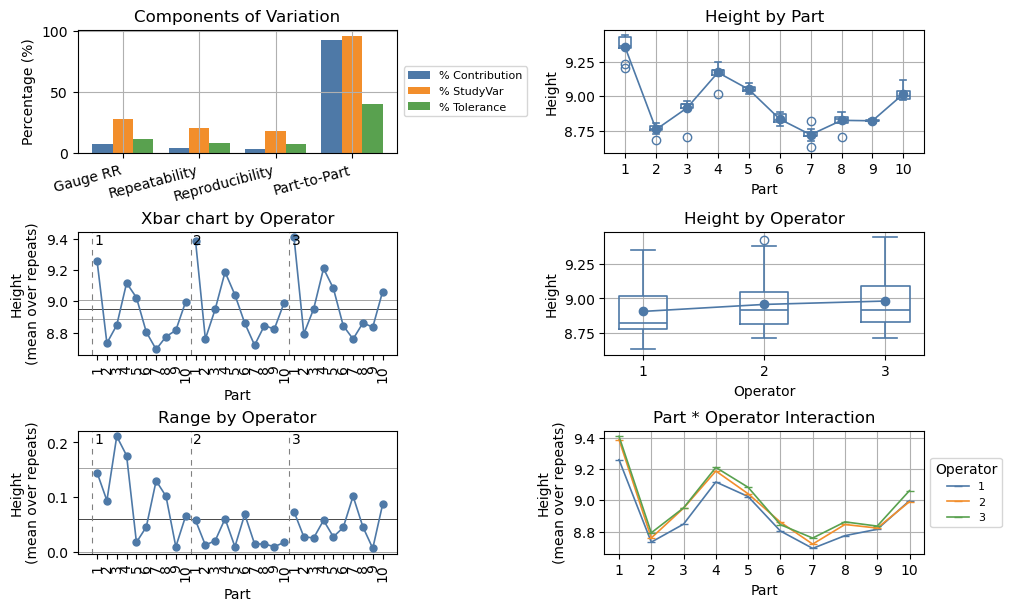

In [7]:
# The `mqr` GRR graphs need 6 axes altogether, 3*2 works well.
with Figure(10, 6, m=3, n=2) as (fig, axs):
    mqr.plot.msa.grr(grr, axs)

The upper left graph shows what the previous table did on contributions.  

The upper right graph shows part-to-part variation is large relative to the within-part measurement errors which is good.  

The middle left graph shows each operator is measuring the parts similarly in terms of average measurement, which is good.  

The middle right graph shows no bias across the operators, which is good.  

The lower left graph shows a problem. The first inspection has 2 to 3 times the variability of the second and third inspector.  That is a problem, inspector 1 needs to improve. They should see how inspection 2 works, and follow that process, for example.  

The lower right graph shows parallel lines, and so there is no one part that is more difficult to measure, which is good.  